<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week10/UCI_HAR_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import math
import os

In [15]:
# --- 1. 설정 및 데이터 전처리 ---

# CUDA 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# !!! 중요 !!!
# UCI HAR Dataset 폴더가 있는 경로를 지정해주세요.
# 예: '/content/drive/MyDrive/Colab Notebooks/UCI-HAR/UCI HAR Dataset/'
# 예: './UCI HAR Dataset/'
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset' # 이 부분을 사용자의 환경에 맞게 수정하세요.

# 하위 폴더 경로 설정
TRAIN_PATH = os.path.join(DATA_PATH, 'train/')
TEST_PATH = os.path.join(DATA_PATH, 'test/')

Using device: cuda


In [16]:
# 원본 Keras 코드의 데이터 로딩 함수 (Pandas 경고 수정)
def load_file(filepath):
    # delim_whitespace=True 대신 sep='\s+' 사용
    dataframe = pd.read_csv(filepath, header=None, sep=r'\s+')
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = os.path.join(prefix, group, 'Inertial Signals/')
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(os.path.join(prefix, group, 'y_'+group+'.txt'))
    return X, y

def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix)
    # load all test
    testX, testy = load_dataset_group('test', prefix)

    # zero-offset class values (1-6 -> 0-5)
    trainy = trainy - 1
    testy = testy - 1

    # PyTorch CrossEntropyLoss는 원-핫 인코딩이 필요 없음.
    # trainy_one_hot = to_categorical(trainy)
    # testy_one_hot = to_categorical(testy)

    print(f"trainX shape: {trainX.shape}, trainy shape: {trainy.shape}")
    print(f"testX shape: {testX.shape}, testy shape: {testy.shape}")

    return trainX, trainy, testX, testy

In [17]:
# 데이터 로드
trainX, trainy, testX, testy = load_dataset(DATA_PATH)

# Train 데이터를 Train/Validation으로 분리
# trainy_one_hot 대신 trainy (레이블 인덱스) 사용
X_train, X_val, y_train, y_val = train_test_split(
    trainX, trainy, test_size=0.2, random_state=42, stratify=trainy
)

# NumPy array를 PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.flatten(), dtype=torch.long) # CrossEntropyLoss를 위해 long 타입 및 1D로 변환
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.flatten(), dtype=torch.long)
X_test_tensor = torch.tensor(testX, dtype=torch.float32)
y_test_tensor = torch.tensor(testy.flatten(), dtype=torch.long)

# 데이터셋 및 데이터로더 생성
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 모델 입력 파라미터 정의
N_TIMESTEPS = X_train.shape[1]  # 128
N_FEATURES = X_train.shape[2]   # 9
N_OUTPUTS = len(np.unique(trainy)) # 6

print(f"Timesteps: {N_TIMESTEPS}, Features: {N_FEATURES}, Outputs: {N_OUTPUTS}")

trainX shape: (7352, 128, 9), trainy shape: (7352, 1)
testX shape: (2947, 128, 9), testy shape: (2947, 1)
Timesteps: 128, Features: 9, Outputs: 6


In [18]:
# --- 2. 모델 정의 (PyTorch) ---

# 1. Simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()
        # (N, C, L) -> (N, 128, 128/2/2 = 32)
        self.fc1 = nn.Linear(128 * (N_TIMESTEPS // 4), 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.permute(0, 2, 1)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# 2. LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=0.2)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (N, L, C) - batch_first=True

        # LSTM은 (h_n, c_n)을 반환
        # h_n shape: (num_layers, N, hidden_dim)
        _, (h_n, _) = self.lstm(x)

        # 마지막 레이어의 마지막 hidden state 사용
        # (N, hidden_dim)
        out = h_n[-1, :, :]
        out = self.fc(out)
        return out

# 3. GRU
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=0.2)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # h_n shape: (num_layers, N, hidden_dim)
        _, h_n = self.gru(x)

        # 마지막 레이어의 마지막 hidden state 사용
        out = h_n[-1, :, :]
        out = self.fc(out)
        return out

# 4. CNN + LSTM
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_dim, conv_out, hidden_dim, output_dim, num_lstm_layers):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=conv_out, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # CNN 출력 (N, conv_out, N_TIMESTEPS // 2)
        # LSTM 입력 (N, L, C)
        self.lstm = nn.LSTM(conv_out, hidden_dim, num_lstm_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.permute(0, 2, 1)
        x = self.pool1(self.relu1(self.conv1(x)))

        # (N, C_conv, L_conv) -> (N, L_conv, C_conv)
        x = x.permute(0, 2, 1)

        _, (h_n, _) = self.lstm(x)

        out = h_n[-1, :, :]
        out = self.fc(out)
        return out

# 5. CNN + GRU
class CNN_GRU_Model(nn.Module):
    def __init__(self, input_dim, conv_out, hidden_dim, output_dim, num_gru_layers):
        super(CNN_GRU_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=conv_out, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.gru = nn.GRU(conv_out, hidden_dim, num_gru_layers,
                          batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.permute(0, 2, 1)
        x = self.pool1(self.relu1(self.conv1(x)))

        # (N, C_conv, L_conv) -> (N, L_conv, C_conv)
        x = x.permute(0, 2, 1)

        _, h_n = self.gru(x)

        out = h_n[-1, :, :]
        out = self.fc(out)
        return out

# 6. ResNet (1D)
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

class ResNet1D(nn.Module):
    def __init__(self, block, num_blocks, input_dim, output_dim):
        super(ResNet1D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, output_dim)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.permute(0, 2, 1)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

# 7. Transformer
# (Positional Encoding 헬퍼 클래스)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (N, L, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, n_head, num_encoder_layers, dim_feedforward, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model

        # 1. 입력 임베딩 (Conv1D 사용)
        self.conv_embed = nn.Conv1d(input_dim, d_model, kernel_size=3, padding=1)

        # 2. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=N_TIMESTEPS + 1) # +1 for CLS token

        # 3. [CLS] 토큰
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # 4. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_head,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # (N, L, E)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # 5. Classification Head
        self.fc_head = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # x: (N, L, C_in) = (N, 128, 9)

        # Conv Embedding
        # (N, C_in, L)
        x = x.permute(0, 2, 1)
        x = self.conv_embed(x)
        # (N, d_model, L) -> (N, L, d_model)
        x = x.permute(0, 2, 1)

        # CLS 토큰 추가
        # self.cls_token: (1, 1, d_model) -> (N, 1, d_model)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # (N, L+1, d_model)

        # Positional Encoding
        x = self.pos_encoder(x)

        # Transformer Encoder
        x = self.transformer_encoder(x) # (N, L+1, d_model)

        # CLS 토큰의 출력만 사용
        cls_output = x[:, 0, :] # (N, d_model)

        # Classifier
        out = self.fc_head(cls_output)
        return out

In [19]:
# --- 3. 학습 및 평가 함수 ---

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        loss.backward()
        # === !!! 수정된 부분 !!! ===
        # 그래디언트 폭주(exploding gradients) 방지를 위한 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # ==========================
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)

    return epoch_loss, epoch_acc.item()

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)

    return epoch_loss, epoch_acc.item()

# 테스트셋 전체에 대한 예측 및 실제 값 반환 (sklearn용)
def get_test_results(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [20]:
# --- 4. 모델 학습 및 평가 실행 ---

# 하이퍼파라미터
N_EPOCHS = 20 # ResNet, Transformer는 30-40 epoch 권장
LEARNING_RATE = 0.001
HIDDEN_DIM = 128
NUM_LAYERS = 2

# 모델 정의
models = {
    "1. Simple CNN": SimpleCNN(N_FEATURES, N_OUTPUTS),
    "2. LSTM": LSTMModel(N_FEATURES, HIDDEN_DIM, N_OUTPUTS, NUM_LAYERS),
    "3. GRU": GRUModel(N_FEATURES, HIDDEN_DIM, N_OUTPUTS, NUM_LAYERS),
    "4. CNN + LSTM": CNN_LSTM_Model(N_FEATURES, 64, HIDDEN_DIM, N_OUTPUTS, NUM_LAYERS),
    "5. CNN + GRU": CNN_GRU_Model(N_FEATURES, 64, HIDDEN_DIM, N_OUTPUTS, NUM_LAYERS),
    # ResNet18과 유사한 1D 구조 (num_blocks = [2, 2, 2, 2])
    "6. ResNet1D": ResNet1D(BasicBlock1D, [2, 2, 2, 2], N_FEATURES, N_OUTPUTS),
    "7. Transformer": TransformerModel(
        input_dim=N_FEATURES,
        d_model=64,
        n_head=4,
        num_encoder_layers=3,
        dim_feedforward=128,
        output_dim=N_OUTPUTS
    )
}


--- Training 1. Simple CNN ---
Epoch 01/20 | Train Loss: 0.6135 | Train Acc: 0.7421 | Val Loss: 0.3568 | Val Acc: 0.8538
Epoch 02/20 | Train Loss: 0.2263 | Train Acc: 0.9186 | Val Loss: 0.1754 | Val Acc: 0.9347
Epoch 03/20 | Train Loss: 0.1340 | Train Acc: 0.9451 | Val Loss: 0.1540 | Val Acc: 0.9368
Epoch 04/20 | Train Loss: 0.1316 | Train Acc: 0.9449 | Val Loss: 0.1306 | Val Acc: 0.9538
Epoch 05/20 | Train Loss: 0.1177 | Train Acc: 0.9481 | Val Loss: 0.1194 | Val Acc: 0.9436
Epoch 06/20 | Train Loss: 0.1077 | Train Acc: 0.9531 | Val Loss: 0.1028 | Val Acc: 0.9572
Epoch 07/20 | Train Loss: 0.1054 | Train Acc: 0.9515 | Val Loss: 0.1266 | Val Acc: 0.9551
Epoch 08/20 | Train Loss: 0.1030 | Train Acc: 0.9543 | Val Loss: 0.0980 | Val Acc: 0.9626
Epoch 09/20 | Train Loss: 0.0989 | Train Acc: 0.9549 | Val Loss: 0.0939 | Val Acc: 0.9599
Epoch 10/20 | Train Loss: 0.0955 | Train Acc: 0.9590 | Val Loss: 0.1580 | Val Acc: 0.9409
Epoch 11/20 | Train Loss: 0.1013 | Train Acc: 0.9594 | Val Loss: 0.0

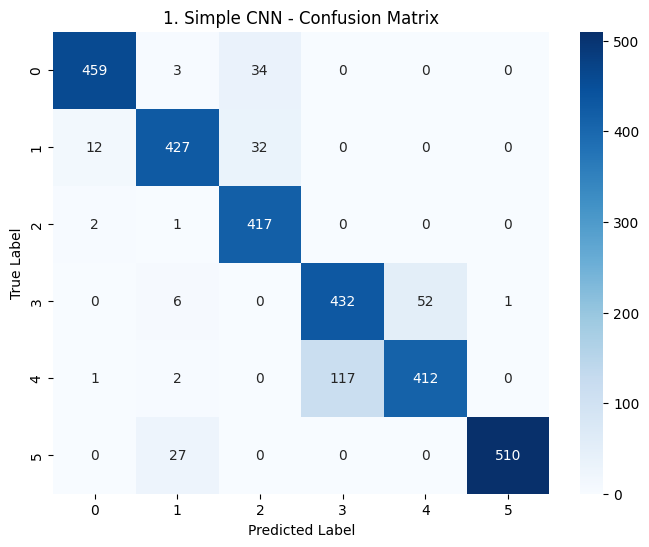


--- Training 2. LSTM ---
Epoch 01/20 | Train Loss: 1.3628 | Train Acc: 0.4059 | Val Loss: 1.0844 | Val Acc: 0.5235
Epoch 02/20 | Train Loss: 0.9966 | Train Acc: 0.5661 | Val Loss: 0.7853 | Val Acc: 0.6832
Epoch 03/20 | Train Loss: 0.7655 | Train Acc: 0.6509 | Val Loss: 0.7173 | Val Acc: 0.6513
Epoch 04/20 | Train Loss: 0.7429 | Train Acc: 0.6429 | Val Loss: 0.7474 | Val Acc: 0.6798
Epoch 05/20 | Train Loss: 0.7394 | Train Acc: 0.6601 | Val Loss: 0.8584 | Val Acc: 0.6200
Epoch 06/20 | Train Loss: 0.7458 | Train Acc: 0.6594 | Val Loss: 0.6784 | Val Acc: 0.7043
Epoch 07/20 | Train Loss: 0.7058 | Train Acc: 0.6575 | Val Loss: 0.7023 | Val Acc: 0.6988
Epoch 08/20 | Train Loss: 0.6774 | Train Acc: 0.6871 | Val Loss: 0.6254 | Val Acc: 0.7158
Epoch 09/20 | Train Loss: 0.7510 | Train Acc: 0.6902 | Val Loss: 1.0088 | Val Acc: 0.6329
Epoch 10/20 | Train Loss: 0.8157 | Train Acc: 0.6613 | Val Loss: 0.7821 | Val Acc: 0.6825
Epoch 11/20 | Train Loss: 0.6184 | Train Acc: 0.7293 | Val Loss: 0.4842 | 

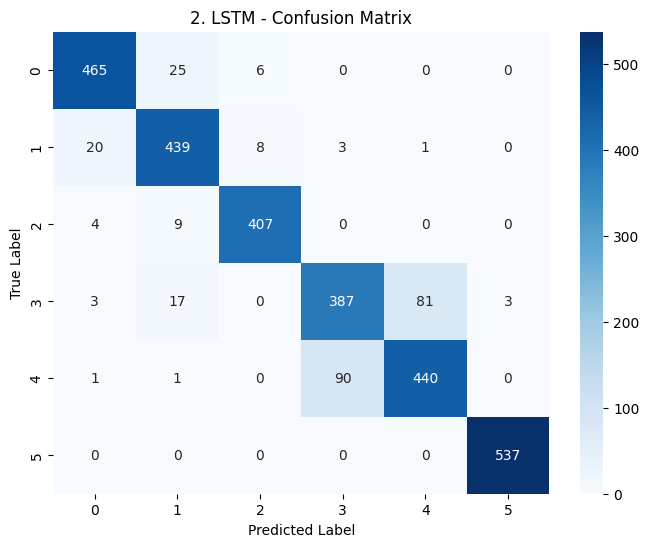


--- Training 3. GRU ---
Epoch 01/20 | Train Loss: 1.1960 | Train Acc: 0.4901 | Val Loss: 0.9648 | Val Acc: 0.5894
Epoch 02/20 | Train Loss: 0.7845 | Train Acc: 0.6696 | Val Loss: 0.6018 | Val Acc: 0.7430
Epoch 03/20 | Train Loss: 0.4241 | Train Acc: 0.8439 | Val Loss: 0.2934 | Val Acc: 0.9171
Epoch 04/20 | Train Loss: 0.2599 | Train Acc: 0.9121 | Val Loss: 0.3221 | Val Acc: 0.8899
Epoch 05/20 | Train Loss: 0.2176 | Train Acc: 0.9194 | Val Loss: 0.2058 | Val Acc: 0.9245
Epoch 06/20 | Train Loss: 0.1620 | Train Acc: 0.9383 | Val Loss: 0.1457 | Val Acc: 0.9545
Epoch 07/20 | Train Loss: 0.1639 | Train Acc: 0.9364 | Val Loss: 0.1752 | Val Acc: 0.9218
Epoch 08/20 | Train Loss: 0.1444 | Train Acc: 0.9456 | Val Loss: 0.1323 | Val Acc: 0.9477
Epoch 09/20 | Train Loss: 0.1384 | Train Acc: 0.9442 | Val Loss: 0.1247 | Val Acc: 0.9579
Epoch 10/20 | Train Loss: 0.1356 | Train Acc: 0.9424 | Val Loss: 0.1210 | Val Acc: 0.9545
Epoch 11/20 | Train Loss: 0.1287 | Train Acc: 0.9486 | Val Loss: 0.1164 | V

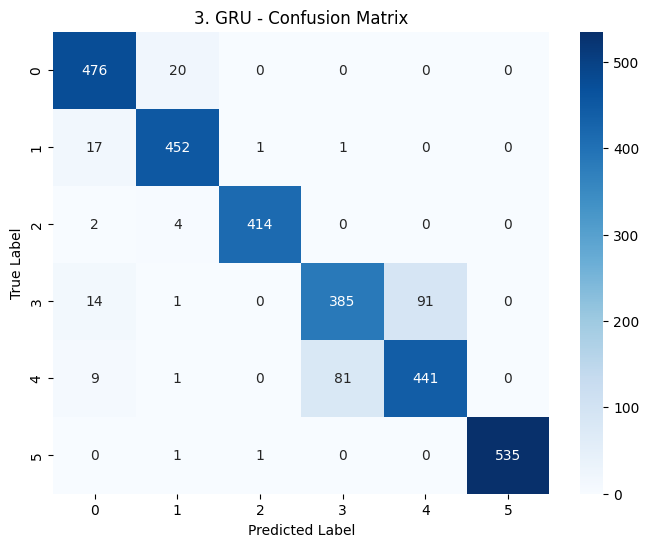


--- Training 4. CNN + LSTM ---
Epoch 01/20 | Train Loss: 1.2114 | Train Acc: 0.4460 | Val Loss: 0.8725 | Val Acc: 0.5112
Epoch 02/20 | Train Loss: 0.9801 | Train Acc: 0.5288 | Val Loss: 0.7830 | Val Acc: 0.5384
Epoch 03/20 | Train Loss: 0.6774 | Train Acc: 0.6764 | Val Loss: 0.5182 | Val Acc: 0.7437
Epoch 04/20 | Train Loss: 0.4857 | Train Acc: 0.7771 | Val Loss: 0.4060 | Val Acc: 0.8362
Epoch 05/20 | Train Loss: 0.3671 | Train Acc: 0.8538 | Val Loss: 0.3343 | Val Acc: 0.8926
Epoch 06/20 | Train Loss: 0.2604 | Train Acc: 0.9140 | Val Loss: 0.2083 | Val Acc: 0.9409
Epoch 07/20 | Train Loss: 0.2126 | Train Acc: 0.9298 | Val Loss: 0.2030 | Val Acc: 0.9320
Epoch 08/20 | Train Loss: 0.1510 | Train Acc: 0.9435 | Val Loss: 0.1451 | Val Acc: 0.9545
Epoch 09/20 | Train Loss: 0.1494 | Train Acc: 0.9507 | Val Loss: 0.1566 | Val Acc: 0.9490
Epoch 10/20 | Train Loss: 0.1414 | Train Acc: 0.9476 | Val Loss: 0.1302 | Val Acc: 0.9585
Epoch 11/20 | Train Loss: 0.1428 | Train Acc: 0.9449 | Val Loss: 0.1

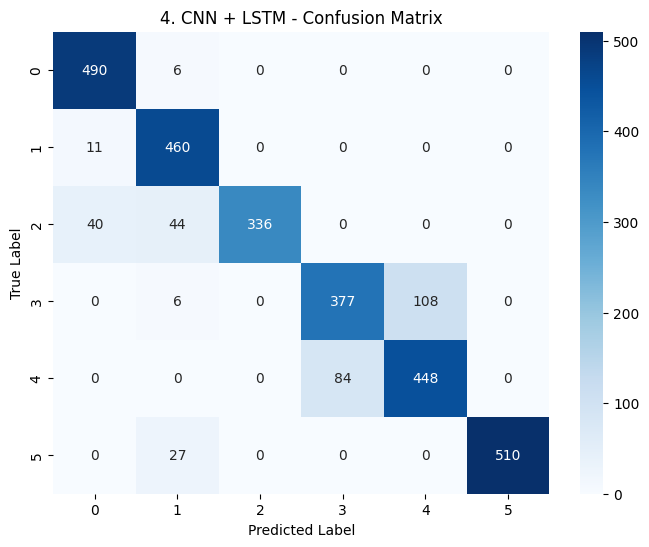


--- Training 5. CNN + GRU ---
Epoch 01/20 | Train Loss: 0.9210 | Train Acc: 0.5803 | Val Loss: 0.7237 | Val Acc: 0.6642
Epoch 02/20 | Train Loss: 0.4458 | Train Acc: 0.8184 | Val Loss: 0.2106 | Val Acc: 0.9395
Epoch 03/20 | Train Loss: 0.1735 | Train Acc: 0.9350 | Val Loss: 0.1411 | Val Acc: 0.9375
Epoch 04/20 | Train Loss: 0.1501 | Train Acc: 0.9379 | Val Loss: 0.1196 | Val Acc: 0.9490
Epoch 05/20 | Train Loss: 0.1310 | Train Acc: 0.9463 | Val Loss: 0.1156 | Val Acc: 0.9619
Epoch 06/20 | Train Loss: 0.1321 | Train Acc: 0.9454 | Val Loss: 0.1258 | Val Acc: 0.9551
Epoch 07/20 | Train Loss: 0.1188 | Train Acc: 0.9509 | Val Loss: 0.1081 | Val Acc: 0.9551
Epoch 08/20 | Train Loss: 0.1126 | Train Acc: 0.9517 | Val Loss: 0.1397 | Val Acc: 0.9456
Epoch 09/20 | Train Loss: 0.1150 | Train Acc: 0.9514 | Val Loss: 0.1209 | Val Acc: 0.9504
Epoch 10/20 | Train Loss: 0.1148 | Train Acc: 0.9517 | Val Loss: 0.1339 | Val Acc: 0.9347
Epoch 11/20 | Train Loss: 0.1133 | Train Acc: 0.9505 | Val Loss: 0.11

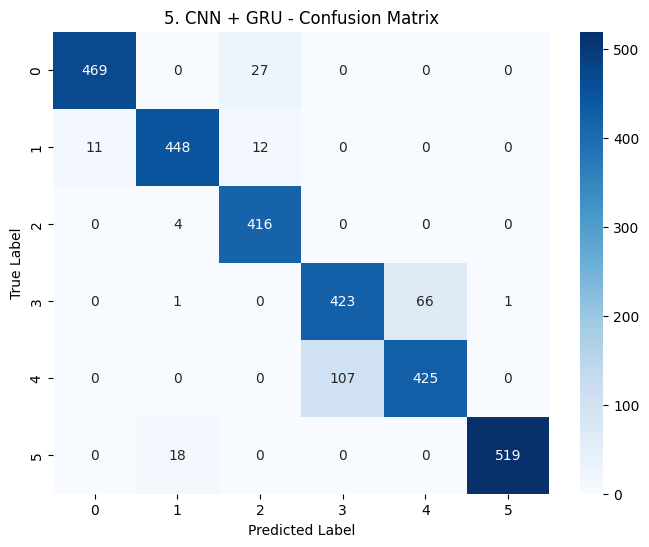


--- Training 6. ResNet1D ---
Epoch 01/20 | Train Loss: 0.3355 | Train Acc: 0.8818 | Val Loss: 0.1470 | Val Acc: 0.9483
Epoch 02/20 | Train Loss: 0.1795 | Train Acc: 0.9347 | Val Loss: 0.1417 | Val Acc: 0.9490
Epoch 03/20 | Train Loss: 0.1567 | Train Acc: 0.9342 | Val Loss: 0.1108 | Val Acc: 0.9449
Epoch 04/20 | Train Loss: 0.1424 | Train Acc: 0.9449 | Val Loss: 0.1241 | Val Acc: 0.9572
Epoch 05/20 | Train Loss: 0.1454 | Train Acc: 0.9417 | Val Loss: 0.1226 | Val Acc: 0.9415
Epoch 06/20 | Train Loss: 0.1285 | Train Acc: 0.9439 | Val Loss: 0.1072 | Val Acc: 0.9504
Epoch 07/20 | Train Loss: 0.1189 | Train Acc: 0.9497 | Val Loss: 0.0903 | Val Acc: 0.9633
Epoch 08/20 | Train Loss: 0.1282 | Train Acc: 0.9459 | Val Loss: 0.1033 | Val Acc: 0.9531
Epoch 09/20 | Train Loss: 0.1155 | Train Acc: 0.9507 | Val Loss: 0.1359 | Val Acc: 0.9463
Epoch 10/20 | Train Loss: 0.1127 | Train Acc: 0.9509 | Val Loss: 0.0832 | Val Acc: 0.9633
Epoch 11/20 | Train Loss: 0.1102 | Train Acc: 0.9515 | Val Loss: 0.099

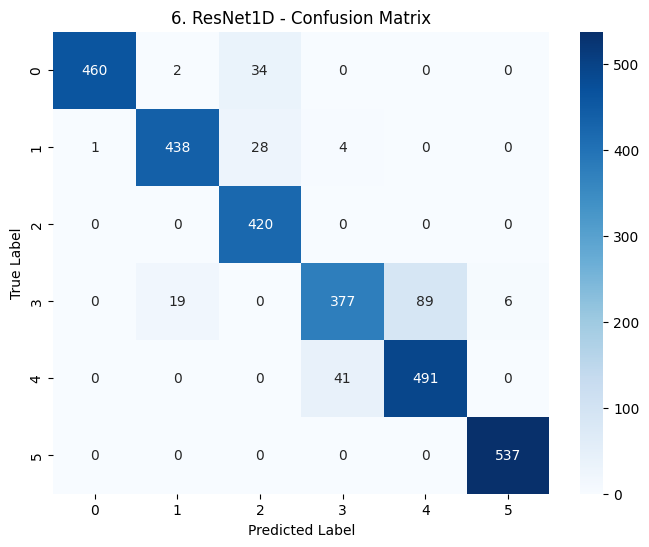


--- Training 7. Transformer ---
Epoch 01/20 | Train Loss: 0.9863 | Train Acc: 0.5875 | Val Loss: 0.4504 | Val Acc: 0.8266
Epoch 02/20 | Train Loss: 0.2779 | Train Acc: 0.9009 | Val Loss: 0.1967 | Val Acc: 0.9368
Epoch 03/20 | Train Loss: 0.1690 | Train Acc: 0.9350 | Val Loss: 0.1356 | Val Acc: 0.9375
Epoch 04/20 | Train Loss: 0.1565 | Train Acc: 0.9367 | Val Loss: 0.1342 | Val Acc: 0.9558
Epoch 05/20 | Train Loss: 0.1498 | Train Acc: 0.9435 | Val Loss: 0.1603 | Val Acc: 0.9286
Epoch 06/20 | Train Loss: 0.1423 | Train Acc: 0.9429 | Val Loss: 0.1174 | Val Acc: 0.9524
Epoch 07/20 | Train Loss: 0.1323 | Train Acc: 0.9466 | Val Loss: 0.1322 | Val Acc: 0.9545
Epoch 08/20 | Train Loss: 0.1336 | Train Acc: 0.9439 | Val Loss: 0.1487 | Val Acc: 0.9436
Epoch 09/20 | Train Loss: 0.1288 | Train Acc: 0.9458 | Val Loss: 0.1312 | Val Acc: 0.9341
Epoch 10/20 | Train Loss: 0.1299 | Train Acc: 0.9493 | Val Loss: 0.1040 | Val Acc: 0.9626
Epoch 11/20 | Train Loss: 0.1256 | Train Acc: 0.9485 | Val Loss: 0.

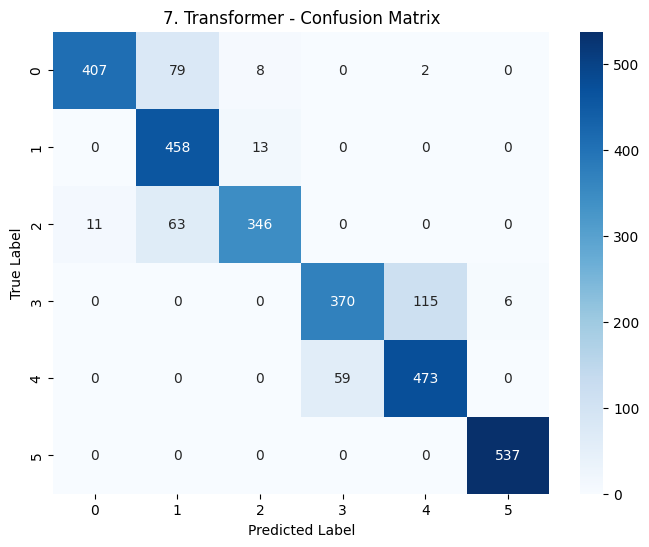

In [21]:
criterion = nn.CrossEntropyLoss()
history = {}

# 각 모델을 순차적으로 학습 및 평가
for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_acc = 0.0
    model_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        model_history['train_loss'].append(train_loss)
        model_history['train_acc'].append(train_acc)
        model_history['val_loss'].append(val_loss)
        model_history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:02}/{N_EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # (선택) 최고 성능 모델 저장
            # torch.save(model.state_dict(), f"{model_name.replace(' ', '_')}_best.pth")

    history[model_name] = model_history

    # --- 테스트셋 평가 ---
    print(f"\n--- 📊 Evaluating {model_name} on Test Set ---")
    y_test_true, y_test_pred = get_test_results(model, test_loader, device)

    test_acc = accuracy_score(y_test_true, y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test_true, y_test_pred, digits=4))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test_true, y_test_pred)
    print(cm)

    # Confusion Matrix 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(6), yticklabels=range(6))
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


--- 📈 All Model Training History ---


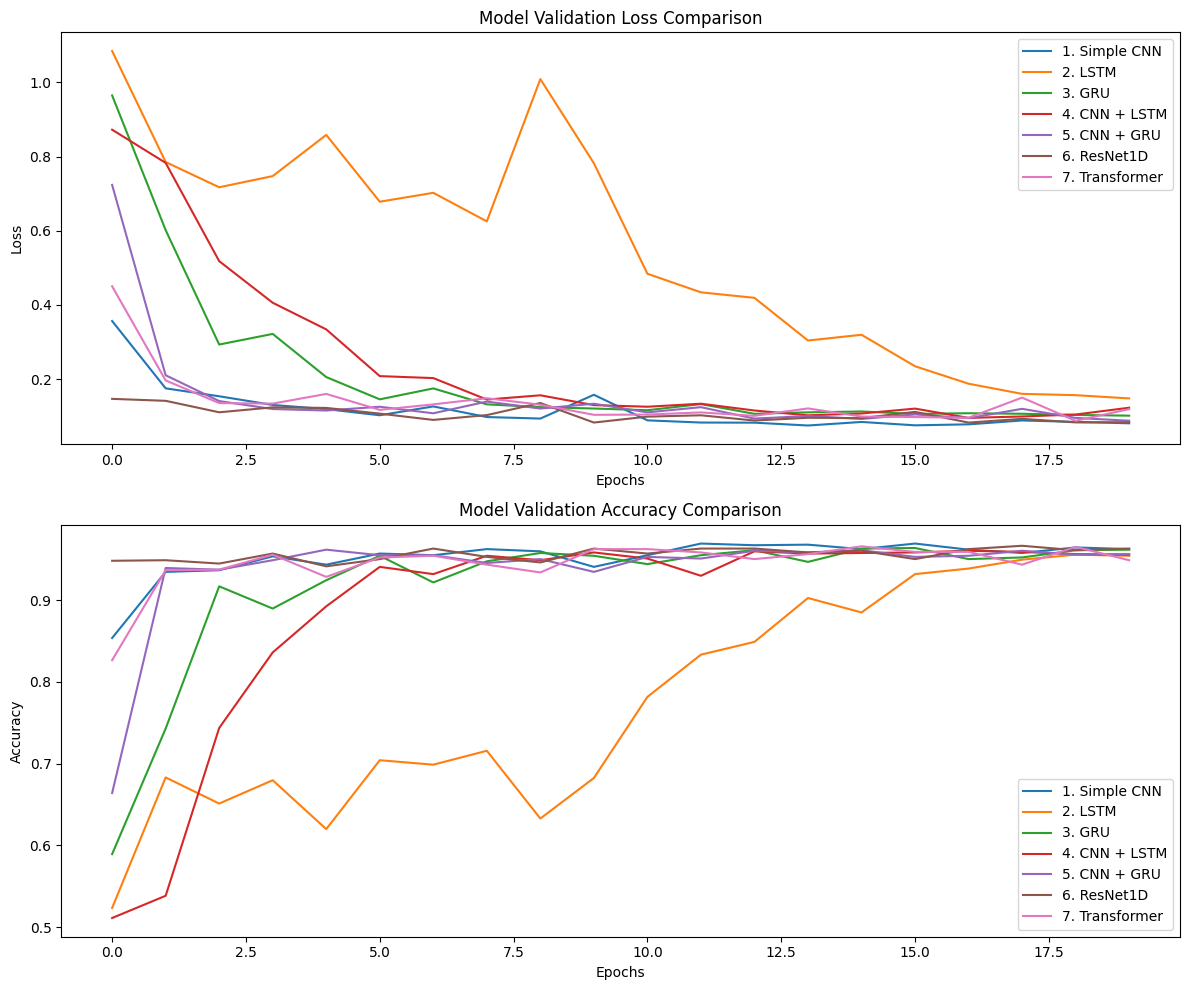

In [22]:
# --- 5. 전체 모델 성능 비교 (학습 곡선) ---
print("\n--- 📈 All Model Training History ---")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Loss 비교
for model_name, h in history.items():
    ax1.plot(h['val_loss'], label=model_name)
ax1.set_title('Model Validation Loss Comparison')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy 비교
for model_name, h in history.items():
    ax2.plot(h['val_acc'], label=model_name)
ax2.set_title('Model Validation Accuracy Comparison')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()